# Conduct sensitivity analysis for T2 and LST

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign, quantile)
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
import matplotlib.patches as mpatches
#from matplotlib.tri import Triangulation
#from cartopy.crs import PlateCarree
#from cartopy.feature import NaturalEarthFeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

#surrogate output filename
LST_surrogate_filename = '../output/LST_klsurrogate_models.pkl'
T2_surrogate_filename = '../output/T2_klsurrogate_models.pkl'

# fvcom grid
# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/'
fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

## Load inputs 

In [5]:
# fvcom grid
fvcom = open_dataset(fvcom_grid_file,decode_times=False, drop_variables=['siglay', 'siglev'])

### parameter info

In [6]:
# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [7]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

### data info

In [8]:
#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [9]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape
ntime__, nlat, nlon = train_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


In [10]:
# Get and check test sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape
ntime__, nlat, nlon = test_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


### forming lake masks

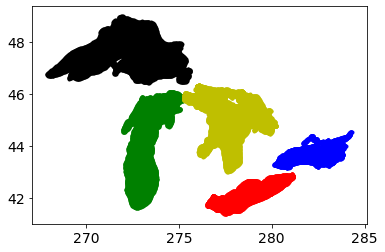

In [76]:
# FVCOM mask
lon = train_dict['LST'][0][1].lon.values
lat = train_dict['LST'][0][1].lat.values
superior = (lat > 46.2) & (lon < 275.9)
plt.plot(lon[superior],lat[superior],'k.')
erie = (lat < 43) & (lon > 275)
plt.plot(lon[erie],lat[erie],'r.')
ontario = (lat > 43) & (lat < 44.55) & (lon > 280)
plt.plot(lon[ontario],lat[ontario],'b.')
michigan = (lat < 46.25) & (lon < 275.25)
plt.plot(lon[michigan],lat[michigan],'g.')
huron = ~((michigan) | (superior) | (erie) | (ontario)) & (lon < 282)
plt.plot(lon[huron],lat[huron],'y.')
plt.show()

lake_dict = {}
lake_dict['LST'] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }

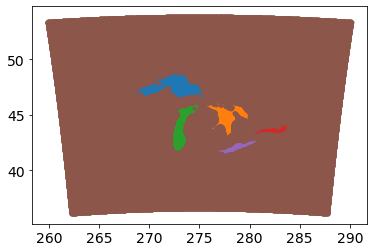

In [77]:
# WRF mask
wrflon = train_dict['T2'][0][1].XLONG.values + 360
wrflat = train_dict['T2'][0][1].XLAT.values
wrf_points = stack((wrflon.flatten(),wrflat.flatten())).transpose()

var = 'T2m'
lake_dict[var] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }
for ll,lake in enumerate(lake_dict[var]):
    lakeI = lake_dict[var][lake]
    kdt = KDTree(stack((lon[lakeI],lat[lakeI])).transpose())
    d,k = kdt.query(wrf_points)
    ii = (d < 5/111).squeeze()
    plt.plot(lon[lakeI],lat[lakeI],'k.')
    plt.plot(wrf_points[ii,0],wrf_points[ii,1],'.')
    lake_dict[var][lake] = ii
    if ll == 0:
        all_lakes = ii
    else:
        all_lakes = ii | all_lakes
    
land = ~all_lakes
plt.plot(wrf_points[land,0],wrf_points[land,1],'.')

In [13]:
# construct the training data into right dimensions
model_data = {}
model_data['LST'] = {}
ntime2 = {}
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['LST'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['train'] = value_temp
    else:
        model_data['LST']['train'] = append(model_data['LST']['train'],value_temp,axis=0)
display(model_data['LST']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['test'] = value_temp
    else:
        model_data['LST']['test'] = append(model_data['LST']['test'],value_temp,axis=0)
assert(ntime2['LST'] == ntime2_)

display(model_data['LST']['test'].shape)

(18, 3288908)

(5, 3288908)

In [14]:
# construct the training data into right dimensions
model_data['T2m'] = {} 
for rdx, run in enumerate(train_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['T2m'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['train'] = value_temp
    else:
        model_data['T2m']['train'] = append(model_data['T2m']['train'],value_temp,axis=0)
display(model_data['T2m']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['test'] = value_temp
    else:
        model_data['T2m']['test'] = append(model_data['T2m']['test'],value_temp,axis=0)
assert(ntime2['T2m'] == ntime2_)

display(model_data['T2m']['test'].shape)

(18, 23915892)

(5, 23915892)

### surrogate models

In [15]:
# load the surrogate models
kl_surrogate = {}
with open(LST_surrogate_filename, 'rb') as fp:
    kl_surrogate['LST'] = pickle.load(fp)
    print('Done loading LST surrogate from binary file')
    
with open(T2_surrogate_filename, 'rb') as fpp:
    kl_surrogate['T2m'] = pickle.load(fpp)
    print('Done loading T2 surrogate from binary file')
    
# surrogate input settings
# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
x_vals = {}
if hot_encode:
    x_vals['train'] = variable_matrix_train
    x_vals['test'] = variable_matrix_test
else:
    x_vals['train'] = ptrain
    x_vals['test'] = ptest

Done loading LST surrogate from binary file
Done loading T2 surrogate from binary file


## Decompose the time series

In [16]:
# some variables for surrogate
var_explained = len(variables) #for PCA

# randomization
random_seeds = range(111,999+111,111)
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

In [17]:
pca_data = {}
for var in model_data:
    trainY = model_data[var]['train']
    testY = model_data[var]['test']
    # Decompose the spatiotemporal series using PCA/KL
    pca_obj = PCA(n_components=var_explained, 
                  random_state=random_seeds[0], 
                  whiten=True)
    pca_obj.fit(trainY)

    print(pca_obj.explained_variance_ratio_)
    print(pca_obj.explained_variance_ratio_.sum())
    print(f'number of eigenmodes is {pca_obj.n_components_}')
    
    pca_data[var] = {}
    # get the outputs from the PCA
    pca_data[var]['klxi_train'] = pca_obj.transform(trainY)
    pca_data[var]['klxi_test']  = pca_obj.transform(testY)
    pca_data[var]['eigenratio'] = pca_obj.explained_variance_ratio_
    pca_data[var]['neig'] = pca_obj.n_components_
    pca_data[var]['eigenvalues'] = pca_obj.explained_variance_
    pca_data[var]['eigenmodes'] = pca_obj.components_
    pca_data[var]['mean_vector'] = pca_obj.mean_

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
0.9133910082750212
number of eigenmodes is 9
[0.6299013  0.09171014 0.06312568 0.03856222 0.03501988 0.02503296
 0.01906686 0.01674813 0.01424874]
0.9334159
number of eigenmodes is 9


### Get LST kl_dicts for all lakes averaged across time

In [25]:
kl_dict = {}
var = 'LST'

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {}
kl_dict[var][' '] = {'eigenmodes': pca_data[var]['eigenmodes'].mean(axis=1).reshape(-1,1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': pca_data[var]['mean_vector'].mean(),    
          }

### Get LST kl_dicts for all lakes and land averaged across time

In [26]:
var = 'T2m'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {}
kl_dict[var]['lake'] = {'eigenmodes': eigenmodes_reshape[:,:,all_lakes].mean(axis=2).mean(axis=1).reshape(-1,1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,all_lakes].mean(), 
          }
kl_dict[var]['land'] = {'eigenmodes': eigenmodes_reshape[:,:,land].mean(axis=2).mean(axis=1).reshape(-1,1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,land].mean(), 
                       }

## Global Sensitivity Analysis

### GSA for LST and T2m

In [27]:
# get all sensitivities
SENSD = {}
for var in ['LST','T2m']: # loop over variables 
    print(var)
    for loc in kl_dict[var]:
        print(loc)
        sens_info = {}
        for sur_type in ['PC','NN']: # loop over surrogate types
            tvs = {} #'main': [], 'total': []}
            for ss, sur in enumerate(kl_surrogate[var][sur_type]):
                sens_sobol, srange = compute_sensitivities(sur, x_vals['train'], sample_size=10000, kl_dict=kl_dict[var][loc])
                if ss == 0:
                    gsa_range = srange
                else:
                    gsa_range = append(gsa_range,srange,axis=0)

                for sens_label in ['main','total']:
                    #portion_of_eigen_explain = sens_eig_sobol[sens_label] #/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
                    #portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
                    #total_var_sens_temp = portion_of_eigen_explain.flatten()
                    #total_var_sens_temp = (portion_of_eigen_explain * pca_data[var]['eigenratio'].reshape(-1,1)).sum(axis=0)/pca_data[var]['eigenratio'].sum()
                    if ss == 0:
                        tvs[sens_label] = sens_sobol[sens_label] #total_var_sens_temp[None,:]
                    else:
                        tvs[sens_label] = append(tvs[sens_label],sens_sobol[sens_label],axis=0) #total_var_sens_temp[None,:],axis=0)

                sens_info[sur_type] = {'gsa_range': gsa_range, 'tvs': tvs}

        SENSD[var + ' ' + loc] = sens_info 

poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


LST
 
Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
T2m
lake
Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)
poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
land
Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)
poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (9,)
parameter common shape: (220000,)
output shape: (9, 220000)


Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL


### Plotting the sensitivities

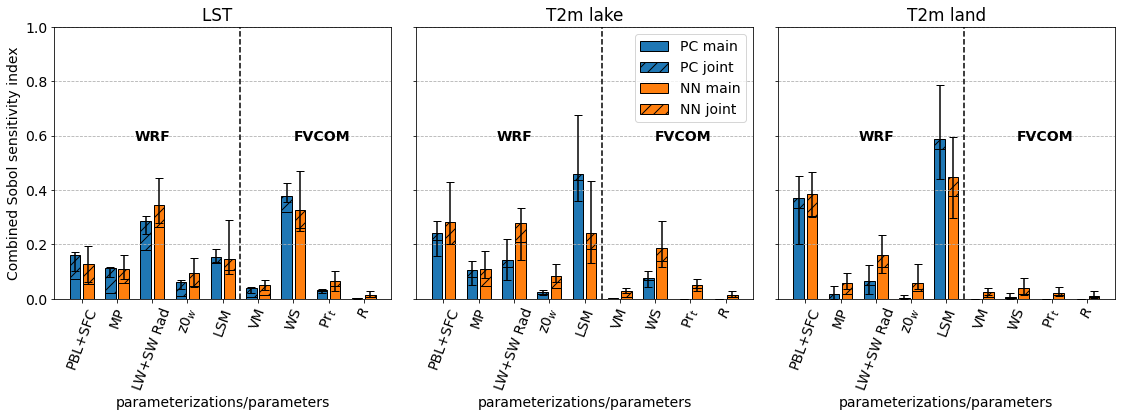

In [28]:
# Plot overall sensitivities by param

# note: make different surrogate models (e.g., different CV and regression for PC 
# and different seed for NN and add error bars to plots)

pname_paper = ['PBL+SFC', 'MP', 'LW+SW Rad', 'z0$_w$', 'LSM', 
               'VM', 'WS', 'Pr$_t$', '$R$']
case_labels = ['main', 'joint']
cases_hatch = [None,'//']
cases_color = ['#1f77b4', '#ff7f0e']
fig, axs = plt.subplots(1, 3,sharey=True,sharex=True,figsize=(19,5))
ind=arange(1, len(variables)+1)
width = 0.3
cases = [0,1]
for kk, key in enumerate(SENSD):
    for st,surrogate_type in enumerate(['PC','NN']):
        tvs = SENSD[key][surrogate_type]['tvs']
        total_var_sens_main = tvs['main'].mean(axis=0).reshape(1,-1)
        total_var_sens_total = tvs['total'].mean(axis=0).reshape(1,-1)
        sensdata = append(total_var_sens_main,
                         fmax(0,total_var_sens_total-total_var_sens_main),
                         axis=0).transpose()
        errordata = append((total_var_sens_total 
                            - tvs['total'].min(axis=0).reshape(1,-1)),
                           (tvs['total'].max(axis=0).reshape(1,-1)
                            - total_var_sens_total),axis=0)
        #errordata = append((total_var_sens_main
        #                    - total_var_sens[surrogate_type]['main'].min(axis=0).reshape(1,-1)),
        #                   (total_var_sens[surrogate_type]['main'].max(axis=0).reshape(1,-1)
        #                    - total_var_sens_main),axis=0)
        curr = zeros(len(variables))
        for i in cases:
            axs[kk].bar(ind+1.25*(st-0.5)*width,
                    sensdata[:, i],
                    width=width,
                    color=cases_color[st],
                    edgecolor='black',
                    hatch=cases_hatch[i],
                    bottom=curr,
                    label=surrogate_type + ' ' + case_labels[i],
            )
            curr += sensdata[:, i]
        axs[kk].errorbar(ind+1.25*(st-0.5)*width,
                     curr,
                     yerr=errordata,
                     fmt=' ',
                     capsize=4,
                     ecolor='k',
        )
    axs[kk].plot([5.5,5.5],[0,1],'k--')
    axs[kk].text(2.5,0.58,'WRF',fontweight='extra bold')
    axs[kk].text(7,0.58,'FVCOM',fontweight='extra bold')
    axs[kk].set_xticks(ind, pname_paper, rotation=70)
    #plt.grid()
    axs[kk].set_ylim([0,1])
    if kk == 0:
        axs[kk].set_ylabel('Combined Sobol sensitivity index')
    axs[kk].set_xlabel('parameterizations/parameters')
    axs[kk].set_title(f'{key}')
    if kk == 1:
        axs[kk].legend()
    axs[kk].yaxis.grid(linestyle='--')

plt.subplots_adjust(wspace=0.075, hspace=0)

plt.savefig('../figures/overall_sensitivities',dpi=600,bbox_inches='tight')
plt.show()   

In [30]:
var = 'T2m'
kl_dict[var][' '] = {'eigenmodes': pca_data[var]['eigenmodes'].mean(axis=1).reshape(-1,1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': pca_data[var]['mean_vector'].mean(),
          }

poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


[16, 20]


poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)


[16, 20]


poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


[18, 22]


poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


[18, 22]


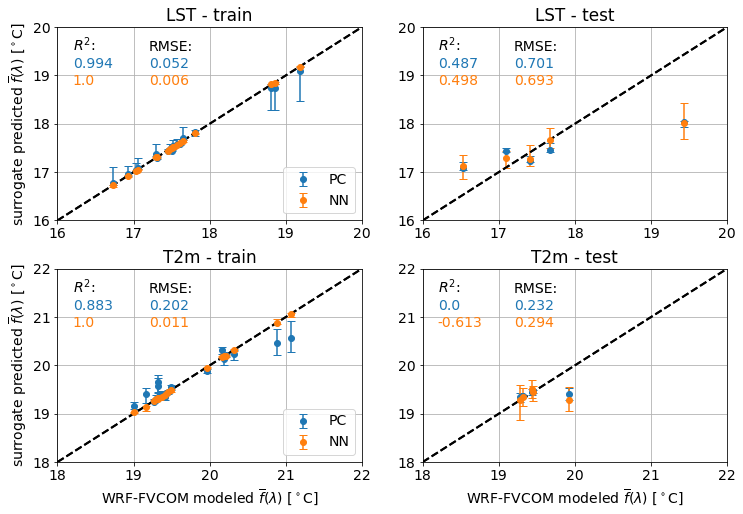

In [31]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined including the range
cases_color = ['#1f77b4', '#ff7f0e']

fig, axs = plt.subplots(2, 2,sharey=False,figsize=(12,8))

for vv,var in enumerate(['LST','T2m']):
    bnds = [16+2*vv,20+2*vv] 
    for ii, comparison in enumerate(['train','test']):

        klxi_model = model_data[var][comparison].mean(axis=1)
        # pc
        for ss, sur in enumerate(kl_surrogate[var]['PC']):
            klxi_pred = surrogate_model_predict(sur,x_vals[comparison], kl_dict=kl_dict[var][' '])
            if ss == 0:
                klxi_preds0 = klxi_pred
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred,axis=1)
        # nn
        for ss, sur in enumerate(kl_surrogate[var]['NN']):
            klxi_pred = surrogate_model_predict(sur,x_vals[comparison].values,kl_dict=kl_dict[var][' '])
            if ss == 0:
                klxi_preds = klxi_pred
            else:
                klxi_preds = append(klxi_preds,klxi_pred,axis=1)

        model_w =  klxi_model
        pred_w = {'NN':  klxi_preds,
                  'PC':  klxi_preds0}
        #model_w = (sqrt(eigenvalues)*klxi_model).sum(axis=1)/sqrt(eigenvalues).sum()
        #pred_w = {'NN':  zeros(klxi_preds[:,:,0].shape),
        #          'PC':  zeros(klxi_preds0[:,:,0].shape)}
        #for ss,klxi_pred in enumerate(klxi_preds):
        #    pred_w['NN'][ss,:] = (sqrt(eigenvalues)*klxi_pred).sum(axis=1)/sqrt(eigenvalues).sum()
        #for ss,klxi_pred0 in enumerate(klxi_preds0):
        #    pred_w['PC'][ss,:] = (sqrt(eigenvalues)*klxi_pred0).sum(axis=1)/sqrt(eigenvalues).sum()

        axs[vv,ii].text(bnds[0]+0.2,bnds[1]-0.5,'$R^2$:')
        axs[vv,ii].text(bnds[0]+1.2,bnds[1]-0.5,'RMSE:')
        for st,surrogate_type in enumerate(['PC','NN']):
            pred_wm = pred_w[surrogate_type].mean(axis=1)
            pred_werror = abs(stack((pred_w[surrogate_type].min(axis=1),
                                     pred_w[surrogate_type].max(axis=1))) - pred_wm)
            axs[vv,ii].errorbar(model_w, pred_wm,
                            yerr=pred_werror,
                            fmt='o',
                            capsize=4,
                            label=surrogate_type,
                            color=cases_color[st])
            u = ((model_w - pred_wm)**2).sum()
            v = ((model_w - model_w.mean())**2).sum()
            r2 = 1 - u/v
            rmse = sqrt(((model_w - pred_wm)**2).mean())
            axs[vv,ii].text(bnds[0]+0.2,bnds[1]-0.5-(1+st)*0.35,str(round(r2,3)),color=cases_color[st])
            axs[vv,ii].text(bnds[0]+1.2,bnds[1]-0.5-(1+st)*0.35,str(round(rmse,3)),color=cases_color[st])
            axs[vv,ii].plot(bnds, bnds, 'k--', lw=2)
            

        if vv == 1:
            axs[vv,ii].set_xlabel(r'WRF-FVCOM modeled $\overline{f}(\lambda)$ [$^\circ$C]')
        if ii == 0:
            axs[vv,ii].set_ylabel(r'surrogate predicted $\overline{f}(\lambda)$ [$^\circ$C]')

        print(bnds)
        axs[vv,ii].set_xlim(bnds)
        axs[vv,ii].set_ylim(bnds)
        axs[vv,ii].set_title(f'{var} - {comparison}')
        if ii == 0:
            axs[vv,ii].legend(loc='lower right')
        axs[vv,ii].grid()
    
plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.savefig('../figures/surrogate_errors',dpi=600,bbox_inches='tight')
plt.show()

### surrogate prediction uncertainty range

model training set
90% range:  [2.0095360097210957, 2.3775494575500495, 1.7440687179565444]
PC distribution
90% range:  [0.8382078071033732, 1.2755040361773204, 1.0375607509043725]
NN distribution
90% range:  [1.4873504028774498, 1.8680485235330941, 1.4748264389853318]


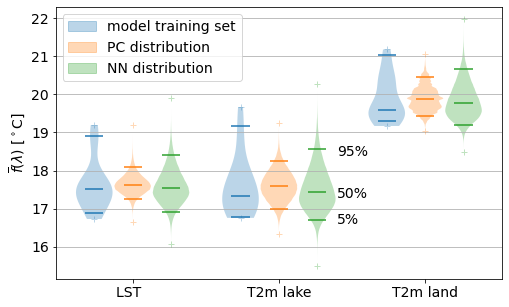

In [47]:
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    return color

# reshape the mean vector and eigenmodes so we can manipulate by dimension
var = 'T2m'
model_data_reshape = model_data['T2m']['train'].reshape(nens_train,ntime2[var],-1)
    
fig = plt.figure(figsize=(8,5))
w = 0.25
qts = [[0.05, 0.95],[0.05, 0.95],[0.05, 0.95]]
for ll,label in enumerate(['model training set','PC distribution','NN distribution']):
    print(label)
    if ll == 0:
        d = [model_data['LST']['train'].mean(axis=1),
            model_data_reshape[:,:,all_lakes].mean(axis=2).mean(axis=1),
            model_data_reshape[:,:,land].mean(axis=2).mean(axis=1)]
    elif ll == 1:
        d = [SENSD[k]['PC']['gsa_range'].flatten() for k in SENSD] 
    elif ll == 2:
        d = [SENSD[k]['NN']['gsa_range'].flatten() for k in SENSD]
        
    dmax = [dd.max() for dd in d]
    dmin = [dd.min() for dd in d]
    pos = [1+1.05*w*(ll-1),2+1.05*w*(ll-1),3+1.05*w*(ll-1)]
    c = add_label(plt.violinplot(d,positions=pos,widths=w,showmedians=True,showextrema=False,quantiles=qts),label=label)
    plt.plot(pos,dmax,'+',color=c)
    plt.plot(pos,dmin,'+',color=c)
    
    print(f'90% range:  {[quantile(dd,0.95) - quantile(dd,0.05) for dd in d]}')

ypos = [18.5,17.4,16.7]
for tt,tx in enumerate(['95%','50%','5%']):
    plt.text(2.4,ypos[tt],tx,horizontalalignment='left',verticalalignment='center')

plt.xticks([1,2,3],labels=[k for k in SENSD])
plt.ylabel(r'$\overline{f}(\lambda)$ [$^\circ$C]')
plt.grid(axis='y')
plt.legend(*zip(*labels), loc='upper left')
plt.savefig('../figures/surrogate_range',dpi=600,bbox_inches='tight')
plt.show()

## Spatially varying sensitivities

### kl_dict temporally averaging

In [104]:
kl_dict = {}
var = 'LST'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

point_array{}
point_array[var] = range(0,eigenmodes_reshape.shape[2],4)

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {'eigenmodes': eigenmodes_reshape[:,:,point_array[var]].mean(axis=1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,point_array[var]].mean(axis=0), 
          }

In [105]:
var = 'T2m'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

point_array[var] = range(0,eigenmodes_reshape.shape[2],10)

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {'eigenmodes': eigenmodes_reshape[:,:,point_array[var]].mean(axis=1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,point_array[var]].mean(axis=0), 
          }

### GSA for LST and T2m in space

In [ ]:
# get all sensitivities
SENSD_spatial = {}
for var in ['LST','T2m']: # loop over variables 
    print(var)
    sens_info = {}
    tvs = {} #'main': [], 'total': []}
    for ss, sur in enumerate(kl_surrogate[var]['NN']):
        sens_sobol, srange = compute_sensitivities(sur, x_vals['train'], sample_size=1000, kl_dict=kl_dict[var])
        if ss == 0:
            gsa_range = srange
        else:
            gsa_range = append(gsa_range,srange,axis=0)

        for sens_label in ['main','total']:
            if ss == 0:
                tvs[sens_label] = sens_sobol[sens_label]
            else:
                tvs[sens_label] += sens_sobol[sens_label]

    for sens_label in ['main','total']:           
        tvs[sens_label] /= len(kl_surrogate[var]['NN'])

    SENSD_spatial[var] = {'gsa_range': gsa_range, 'tvs': tvs}

LST
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL


### Plot of LST spatial variation of sensitivity

In [ ]:
# only choose top 4
pnames_sel = array(pname_paper)[[0,2,4,6]]
print(pnames_sel)

fig, axs = plt.subplots(2, #3, 
                        2, sharey=True, sharex=True, 
                        figsize=(12,5), #(14,10),
                       subplot_kw={'projection': PlateCarree()})
for adx,pname in enumerate(pnames_sel):

    ax = axs.flat[adx]

    # Download and add the states and coastlines
    coast = NaturalEarthFeature(
            category='physical',
            name='coastline',
            facecolor='none',
            scale='50m')
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)
    ax.add_feature(coast)
    
    pdx = pname_paper.index(pname)
    im = ax.scatter(train_dict['LST'][0][1].lon[point_array]-360,
             train_dict['LST'][0][1].lat[point_array],
             c=sens_sobol_x_nn[:,pdx],
             s=2,
             #vmin=0,vmax=1.0,
             transform = PlateCarree(),
             norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
             cmap='magma')     

    ax.set_title(f'{pname}')
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gl.xlabels_top = None
    gl.ylabels_right = None
    if adx < 2: #< 4:
        gl.xlabels_bottom = None
    if adx % 2 == 1:
        gl.ylabels_left = None
        
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), 
                    shrink=0.95, extend='both',label='Total Sobol sensitivity index')
cbar.set_ticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
cbar.set_ticklabels(['0.01','0.02','0.05','0.1','0.2','0.5','1.0'])

plt.suptitle('Spatial variation in LST sensitivity')
plt.show()

## Temporally varying sensitivities

### kl dict for LST across the individual lakes

In [80]:
kl_dict = {}
var = 'LST'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {}
for lake in lake_dict[var]:
    kl_dict[var][lake] = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[var][lake]].mean(axis=2),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,lake_dict[var][lake]].mean(axis=1), 
          }

### kl dict for T2m across the individual lakes

In [82]:
var = 'T2m'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

# use WRF mask to make kl_dict for lake and land..
kl_dict[var] = {}
for lake in lake_dict[var]:
        kl_dict[var][lake] = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[var][lake]].mean(axis=2),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,lake_dict[var][lake]].mean(axis=1), 
          }
kl_dict[var]['land'] = {'eigenmodes': eigenmodes_reshape[:,:,land].mean(axis=2).mean(axis=1).reshape(-1,1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,land].mean(), 
                       }

In [ ]:
sens_sobol_lake = [None] * (len(lake_dict)+1)
nn_ens_min = [None] * (len(lake_dict)+1)
nn_ens_max = [None] * (len(lake_dict)+1)
for ldx,lake in enumerate(lake_dict):
    print(lake)
    # get the sensitivity for the PC surrogate
    kl_dict = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[lake]].mean(axis=2),
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape[:,lake_dict[lake]].mean(axis=1),
          }
    for ss, sur in enumerate(kl_surrogate['NN']):
        this_sens, values = compute_sensitivities(sur, train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
        if ss == 0:
            sens_sobol_lake[ldx] = this_sens['total']
            nn_ens_min[ldx] = values.min(axis=0)
            nn_ens_max[ldx] = values.max(axis=0)
        else:
            sens_sobol_lake[ldx] += this_sens['total']
            nn_ens_min[ldx] = fmin(nn_ens_min[ldx],values.min(axis=0))
            nn_ens_max[ldx] = fmax(nn_ens_max[ldx],values.max(axis=0))

    sens_sobol_lake[ldx] = sens_sobol_lake[ldx]/len(kl_surrogate['NN'])
    
# overall
print('overall')
kl_dict = {'eigenmodes': eigenmodes_reshape.mean(axis=2), 
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape.mean(axis=1),
          }
for ss, sur in enumerate(kl_surrogate['NN']):
    this_sens, values = compute_sensitivities(sur, train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
    if ss == 0:
        sens_sobol_lake[-1] = this_sens['total']
        nn_ens_min[-1] = values.min(axis=0)
        nn_ens_max[-1] = values.max(axis=0)
    else:
        sens_sobol_lake[-1] += this_sens['total']
        nn_ens_min[-1] = fmin(nn_ens_min[-1],values.min(axis=0))
        nn_ens_max[-1] = fmax(nn_ens_max[-1],values.max(axis=0))
        
sens_sobol_lake[-1] = sens_sobol_lake[-1]/len(kl_surrogate['NN'])

plt.plot(nn_ens_min[-1])
plt.plot(nn_ens_max[-1])
plt.ylim([0, 30])

In [ ]:
# get max min pf the model training data
ens_min = [None] * (len(lake_dict)+1)
ens_max = [None] * (len(lake_dict)+1)
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    value_temp = run[1].isel(time=tdx).mean(dim='node').values
    
    plt.plot(value_temp)
    plt.ylim([0, 30])
    
    if rdx == 0:
        ens_min[-1] = value_temp
        ens_max[-1] = value_temp
    else:
        ens_min[-1] = minimum(value_temp,ens_min[-1])
        ens_max[-1] = maximum(value_temp,ens_max[-1])
        
    for ldx, lake in enumerate(lake_dict):
        value_temp = run[1].isel(time=tdx,node=lake_dict[lake]).mean(dim='node').values
        if rdx == 0:
            ens_min[ldx] = value_temp
            ens_max[ldx] = value_temp
        else:
            ens_min[ldx] = minimum(value_temp,ens_min[ldx])
            ens_max[ldx] = maximum(value_temp,ens_max[ldx])

plt.plot(ens_min[-1],'k-')
plt.plot(ens_max[-1],'r--')

In [ ]:
time = train_dict['LST'][0][0]
tdx = (time >= ts) & (time < te)
time = time[tdx]

#fig, axs = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(14,10))
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(14,8))
adx = 0
for ldx, lake in enumerate(lake_dict):
    if lake in ['Huron','Ontario']:
        continue
    ax = axs.flat[adx]
    for pdx,pname in enumerate(pname_paper):
        ax.plot(time,sens_sobol_lake[ldx][:,pdx],label=pname)

    ax.set_title(f'{lake}')
    ax.set_ylim([0,1.0])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.grid()
    
    ax2 = ax.twinx()
    ax2.fill_between(time,nn_ens_min[ldx],nn_ens_max[ldx],color='r',alpha=0.3,label='LST NN range')
    ax2.fill_between(time,ens_min[ldx],ens_max[ldx],color='k',alpha=0.3,label='LST model range')
    #ax2.fill_between(time,pc_ens_min[ldx],pc_ens_max[ldx],color='g',alpha=0.3,label='LST PC range')
    ax2.set_ylim([0,30])
    
    if adx == 2 or adx == 0:
        ax.set_ylabel('Total Sobol sensitivity index')
        ax2.set_ylabel('LST [$^\circ$C]')
    
    adx += 1
    
    #axs.flat[ldx].set_xticks(axs.flat[ldx].get_xticks(), rotation=50)
for pdx,pname in enumerate(pname_paper):
    axs.flat[-1].plot(time,sens_sobol_lake[-1][:,pdx],label=pname)

axs.flat[-1].legend(loc=(1.1,0))
    
ax2 = axs.flat[-1].twinx()
ax2.fill_between(time,nn_ens_min[-1],nn_ens_max[-1],color='r',alpha=0.3,label='LST NN range')
ax2.fill_between(time,ens_min[-1],ens_max[-1],color='k',alpha=0.3,label='LST model range')
#ax2.fill_between(time,pc_ens_min[-1],pc_ens_max[-1],color='g',alpha=0.3,label='LST PC range')
ax2.set_ylim([0,30])

ax2.legend(loc=(1.1,2))

axs.flat[-1].set_title('Overall')
axs.flat[-1].set_ylim([0,1.0])
axs.flat[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs.flat[-1].grid()
    
plt.suptitle('Temporal variation in LST sensitivity')

plt.show()

In [ ]:
for ldx,lake in enumerate(lake_dict):
    print(lake)
    print((nn_ens_max[ldx] - nn_ens_min[ldx]).mean())
    

print('overall')
print((nn_ens_max[-1] - nn_ens_min[-1]).mean())

In [ ]:
point_array = range(0,lon.shape[0],4)
print(point_array)

In [ ]:
# get sensitivity for NN surrogate
kl_dict = {'eigenmodes': eigenmodes_reshape.mean(axis=1)[:,point_array], 
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape.mean(axis=0)[point_array],
          }
for ss, sur in enumerate(kl_surrogate['NN']):
    this_sens, _ = compute_sensitivities(sur, train_x, sample_size=1000,
                                                     kl_dict=kl_dict)
    if ss == 0:
        sens_sobol_x_nn = this_sens['total']
    else:
        sens_sobol_x_nn += this_sens['total']
sens_sobol_x_nn = sens_sobol_x_nn/len(kl_surrogate['NN'])